# About this Notebook

In this notebook, I will showcase how to plot out lat/long coordinates and their cluster centers using geopandas. The data comes from the New York City Trip Duration Kaggle competition from 2017, and this notebook walks through what lat/long coordinates belong to which cluster groups found via minibatch K-Means.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import time 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
from PIL import Image

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform, euclidean, cosine
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
df = pd.read_csv('./data_nyc/train.csv')

In [5]:
print(df.shape)
df.head()

(1458644, 11)


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

# Data Preprocessing

1) Select only pickup latitude and longitude coordinates

2) Filter out extreme outliers that are very far from NYC

In [14]:
df_pickup = df[['pickup_latitude', 'pickup_longitude']].copy()
df_pickup = df_pickup.rename(columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'})


In [15]:
print(df_pickup.shape)
df_pickup.head()

(1458644, 2)


latitude  longitude
0  40.767937 -73.982155
1  40.738564 -73.980415
2  40.763939 -73.979027
3  40.719971 -74.010040
4  40.793209 -73.973053

In [16]:
# Drop lat/longs of extreme outliers below 0.01 percentile or above 99.99 percentile
df_pickup_filtered = df_pickup[(df_pickup.quantile(0.0001) < df_pickup) & (df_pickup < df_pickup.quantile(0.9999))]
df_pickup_filtered = df_pickup_filtered.dropna(how='any')

print(f'{df_pickup.shape[0] - df_pickup_filtered.shape[0]} extreme outliers removed')
print(f'Shape of filtered df_pickup: {df_pickup_filtered.shape}')


485 extreme outliers removed
Shape of filtered df_pickup: (1458159, 2)


# Plotting Coordinates and Clusters onto Map of NYC

In [6]:
def plot_geolocation_by_cluster(df, 
                                cluster=None, 
                                title=None, 
                                centers=None,
                                filename=None):
    '''
    Function to plot latitude and longitude coordinates
    #####################
    Args:
        df: pandas dataframe 
            Contains id, latitude, longitude, and color (optional).
        cluster: (optional) column (string) in df 
            Separate coordinates into different clusters
        title: (optional) string
        centers: (optional) array of coordinates for centers of each cluster
        filename: (optional) string  
    #####################
    Returns:
        Plot with lat/long coordinates 
    '''
    
    # Transform df into geodataframe
    geo_df = gpd.GeoDataFrame(df.drop(['longitude', 'latitude'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])
      
    # Set figure size
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    
    # Import NYC Neighborhood Shape Files
    nyc_full = gpd.read_file('./data_nyc/shapefiles/neighborhoods_nyc.shp')
    nyc_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', label=nyc_full['nta_name'], zorder=1)
    
    # Plot coordinates from geo_df on top of NYC map
    if cluster is not None:
        
        geo_df.plot(ax=ax, column=cluster, alpha=0.5, 
                    cmap='viridis', linewidth=0.8, zorder=2)
        
        if centers is not None:
            centers_gseries = GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
            centers_gseries.plot(ax=ax, alpha=1, marker='X', color='red', markersize=100, zorder=3)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
        if filename is not None:
            fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)
    else:
        geo_df.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8, legend=True, zorder=2)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
    fig.clf()
    
    

# MiniBatch K-Means Clustering

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



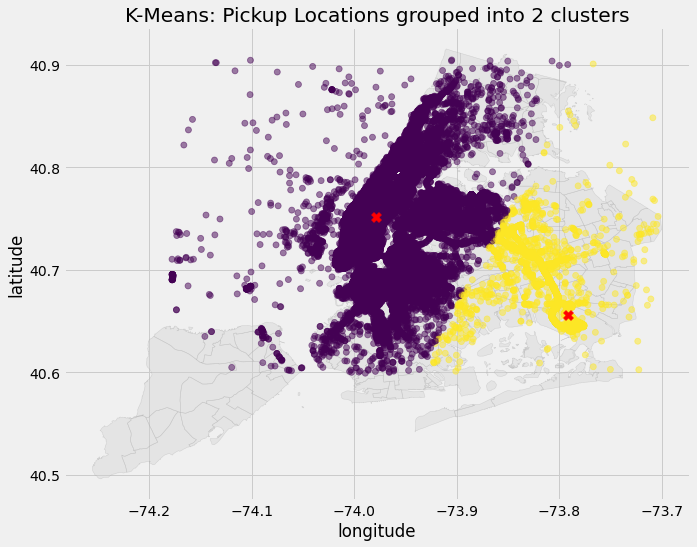

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



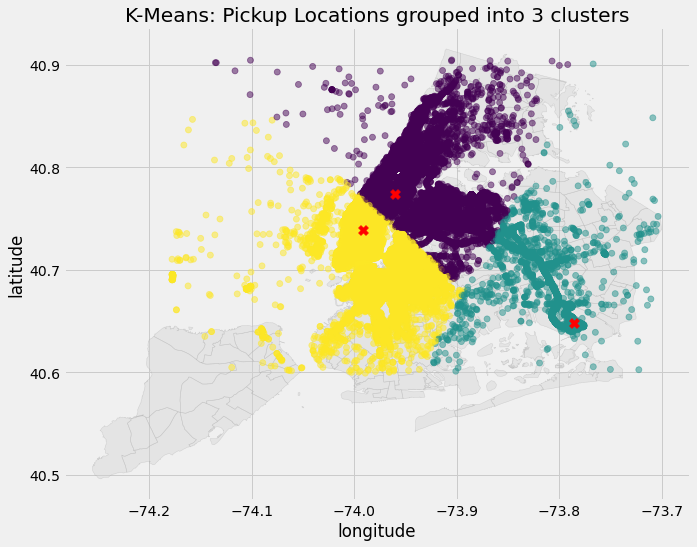

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



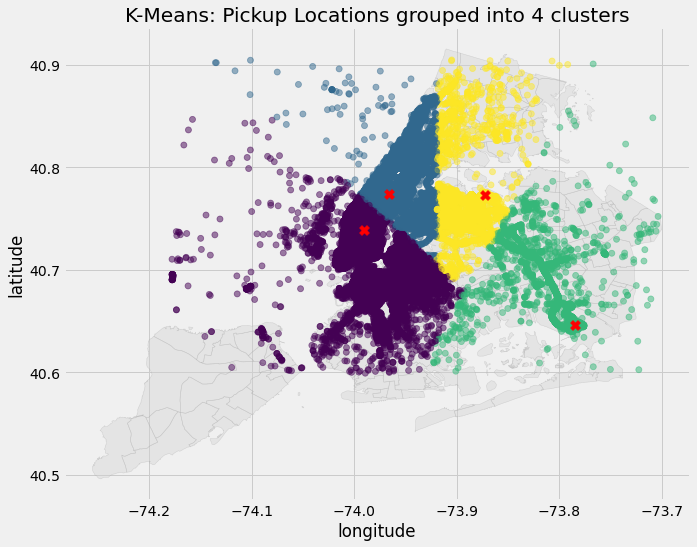

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



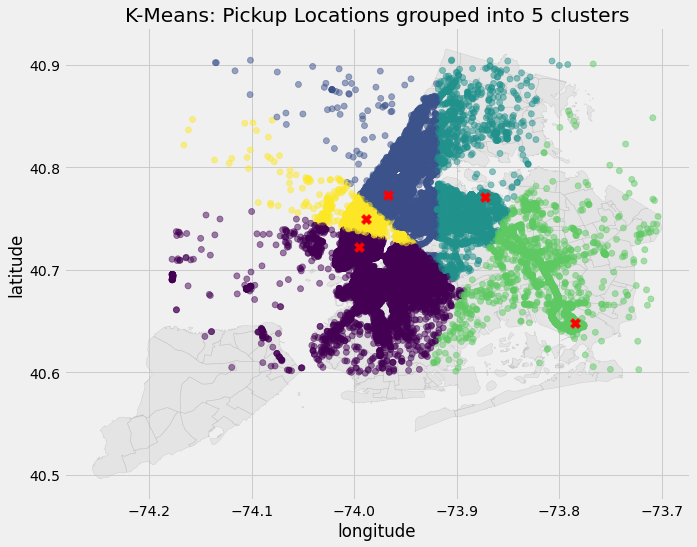

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



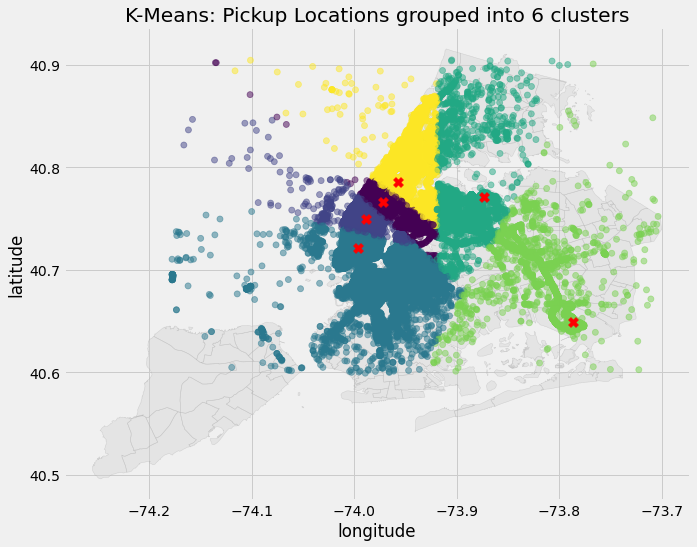

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



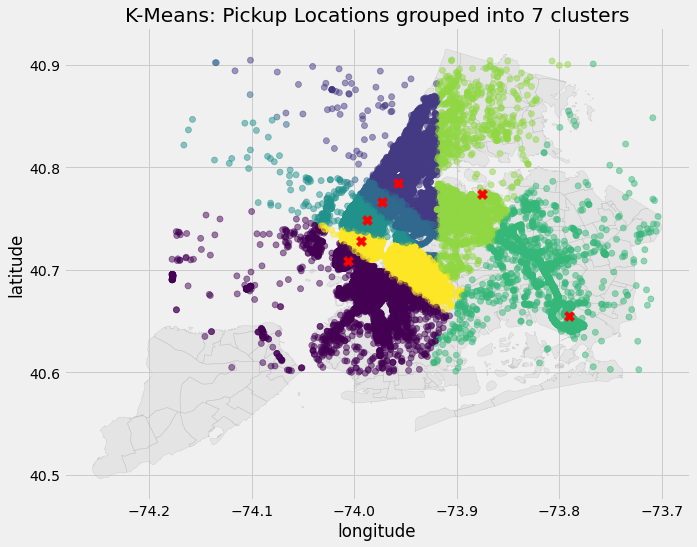

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



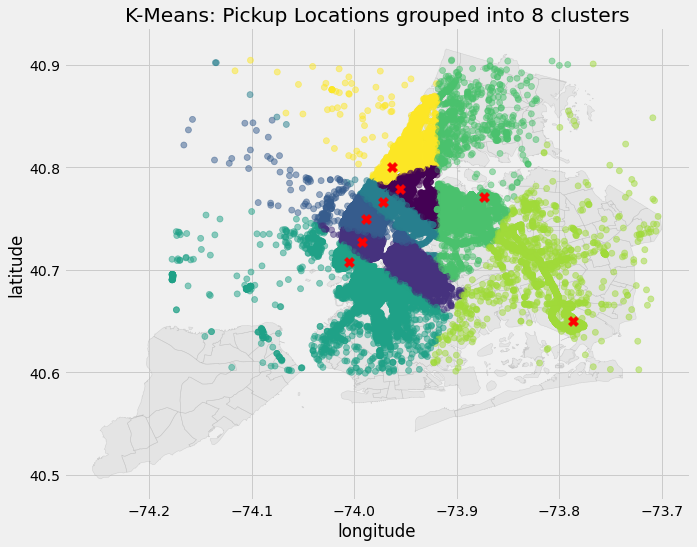

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



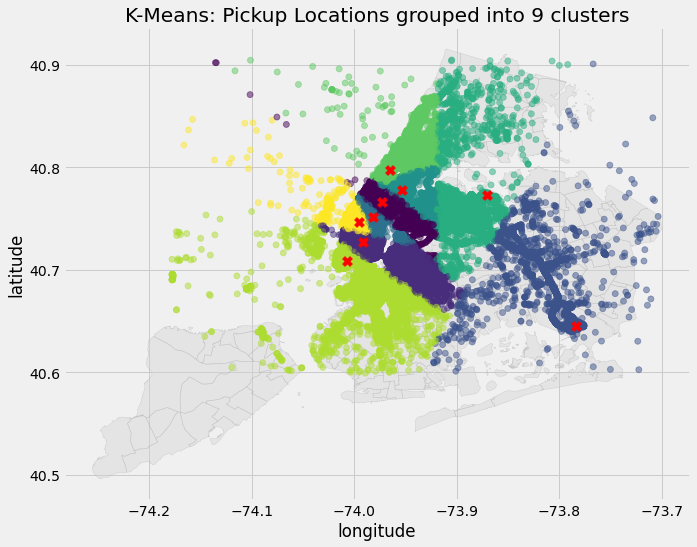

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



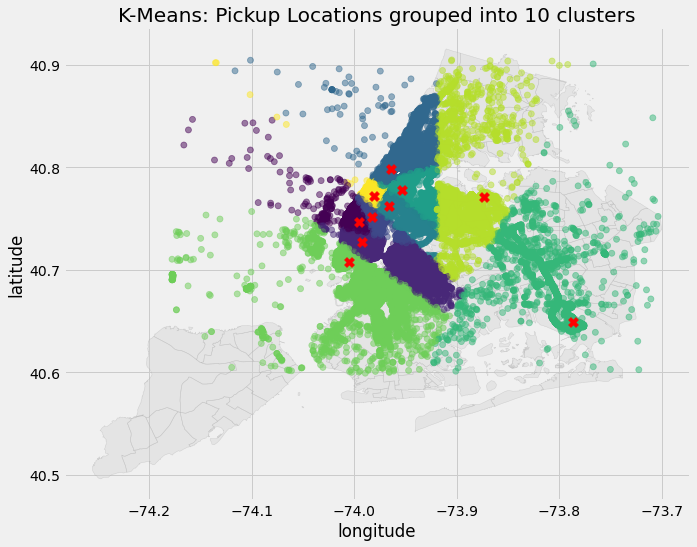

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



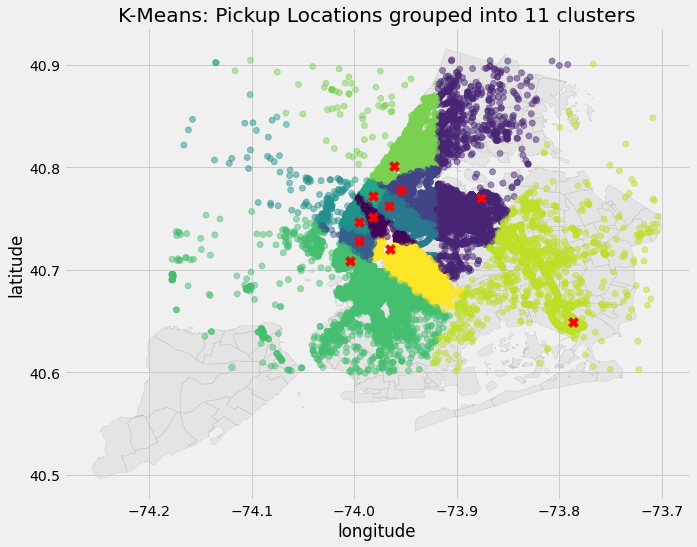

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



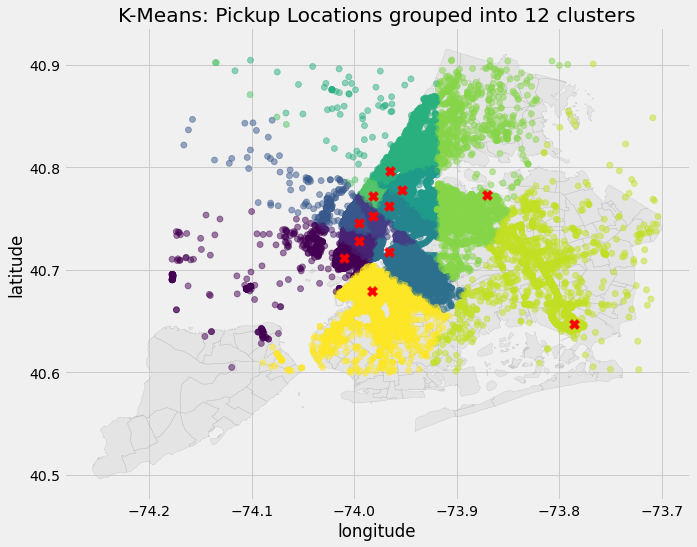

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



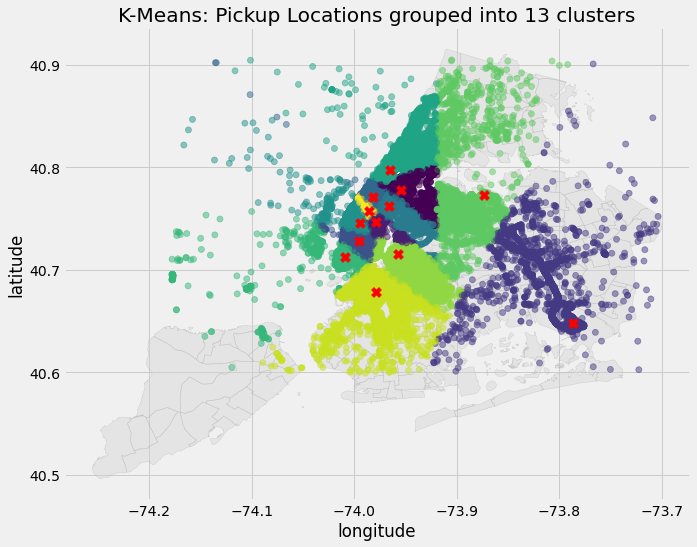

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



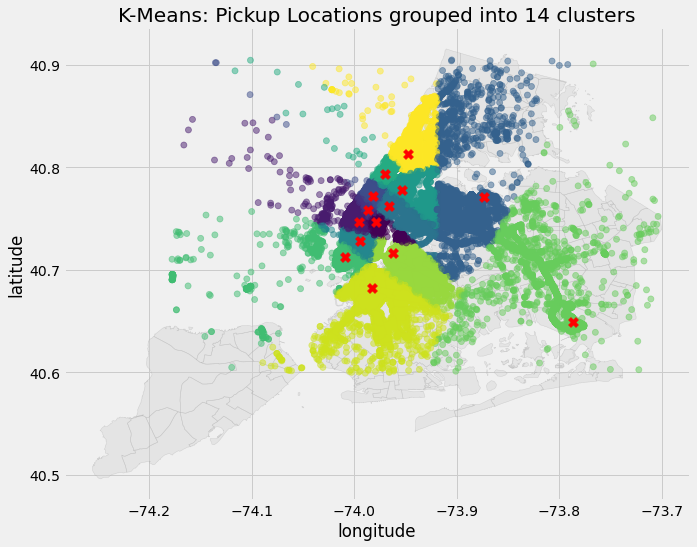

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



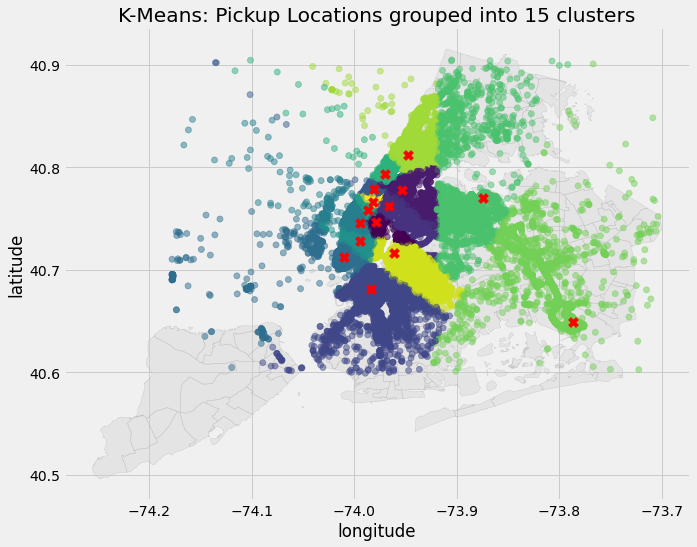

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



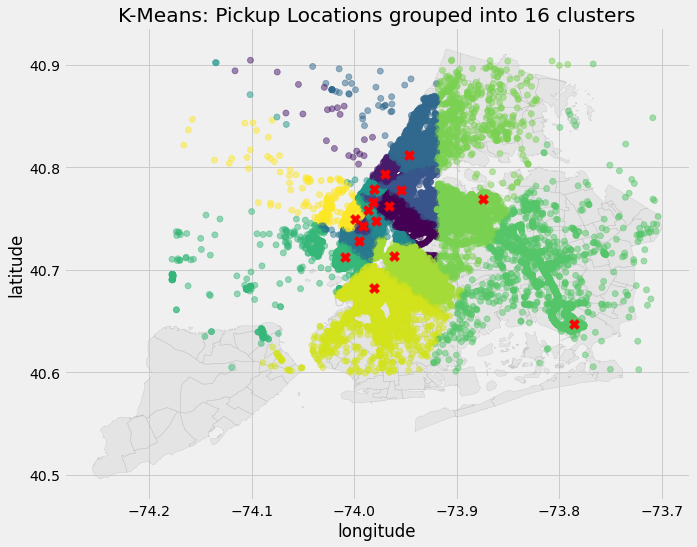

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



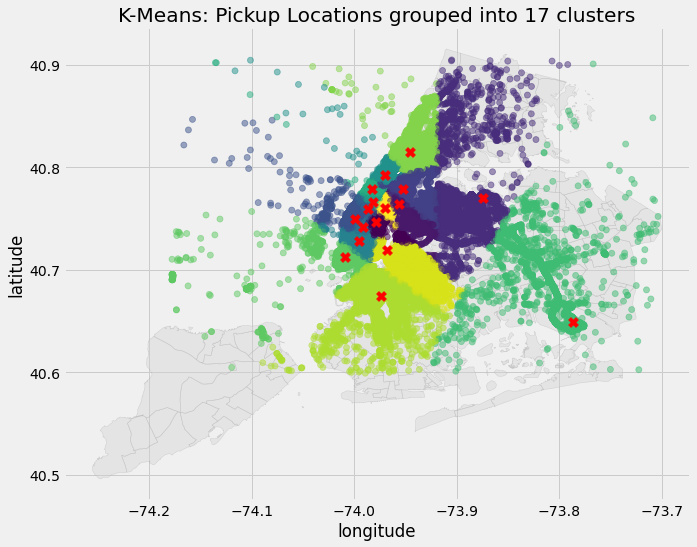

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



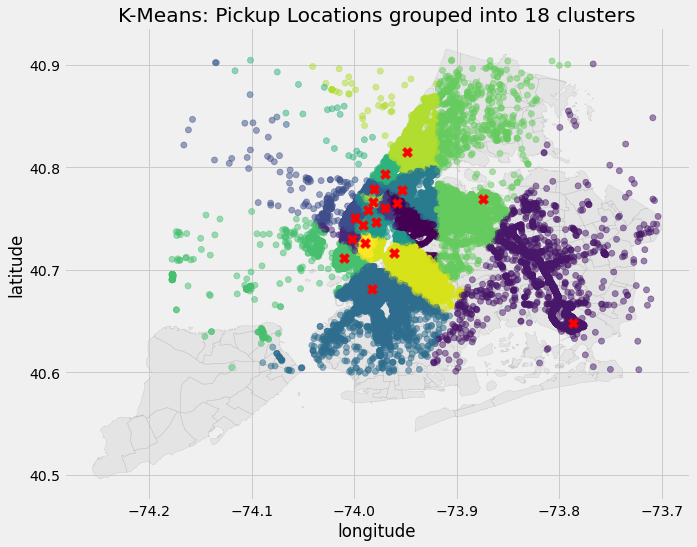

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



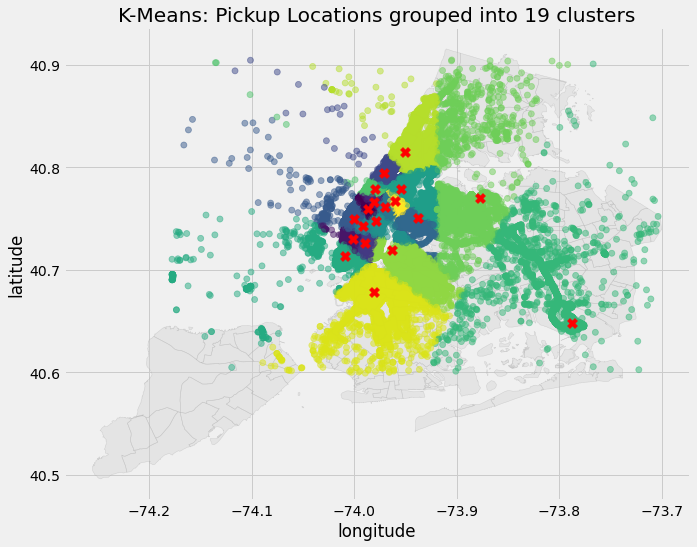

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



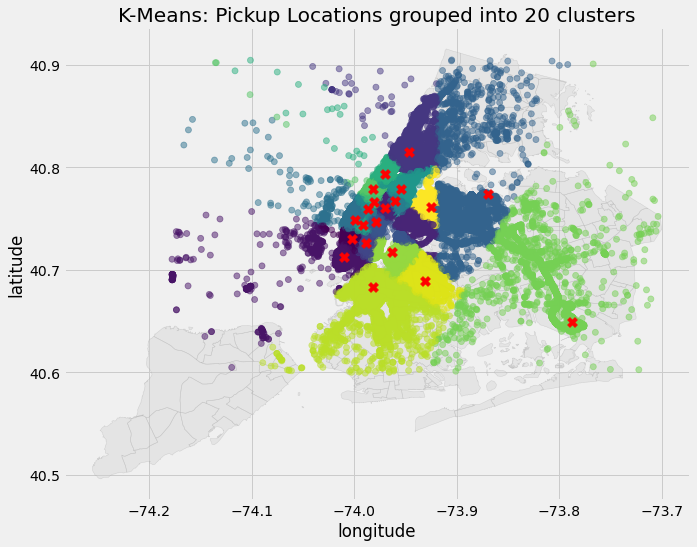

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



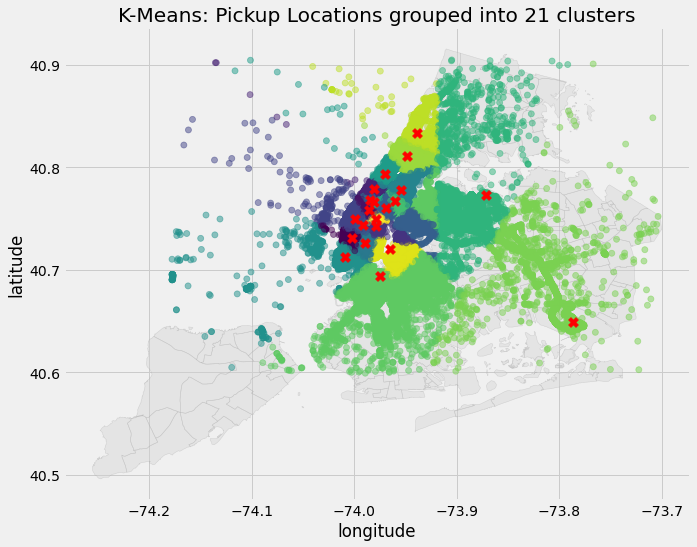

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



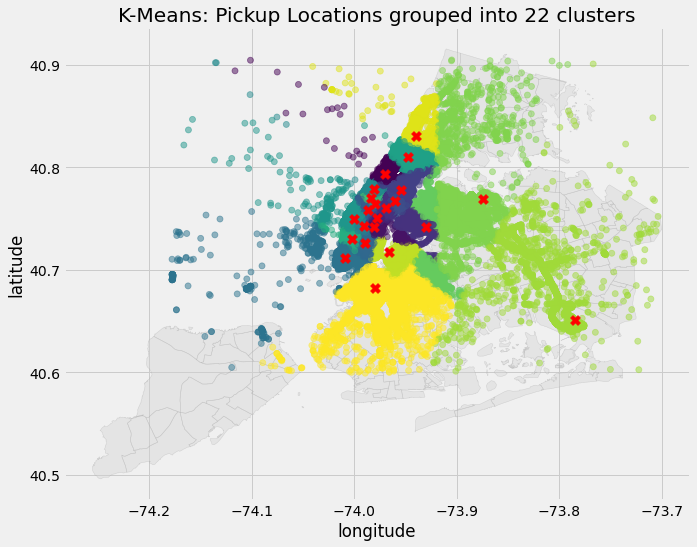

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



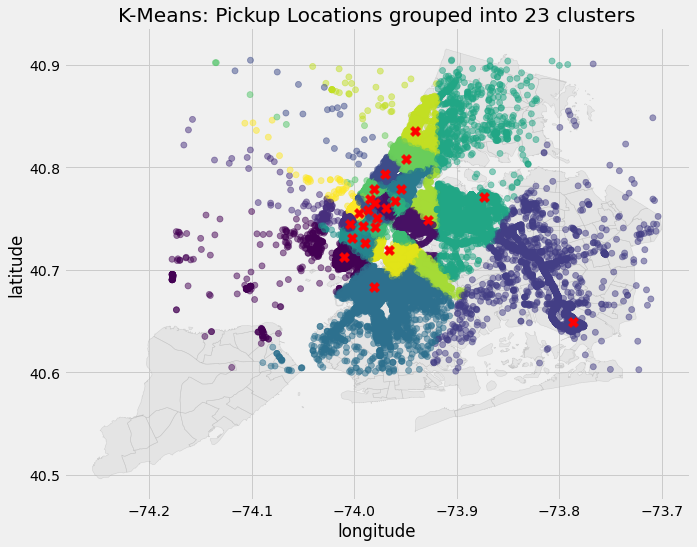

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



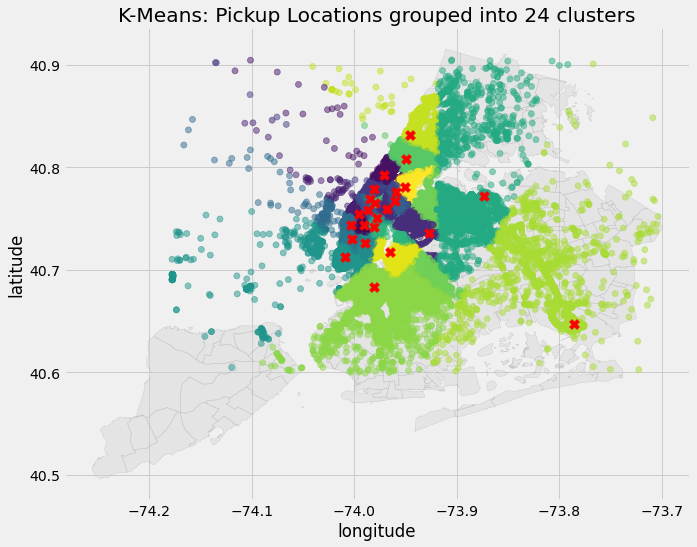

In [21]:
ssd = []

for i in range(2, 26):
    # Find clusters
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(df_pickup_filtered)
    
    # Label cluster centers
    centers = km.cluster_centers_
    
    # Calculate sum of squared distances
    ssd.append(km.inertia_)
    
    # Get cluster center
    df_pickup_filtered['cluster'] = km.labels_
    
    # Plot lat/long and clusters on map
    plot_geolocation_by_cluster(df_pickup_filtered, cluster='cluster', 
                                title= f'K-Means: Pickup Locations grouped into {i} clusters',
                                centers=centers, filename=f'./plots/pickup_kmeans/pickup_kmeans_{i}_clusters.png')

Text(0.5, 1.0, 'Elbow Method to Find Optimal Value of k')

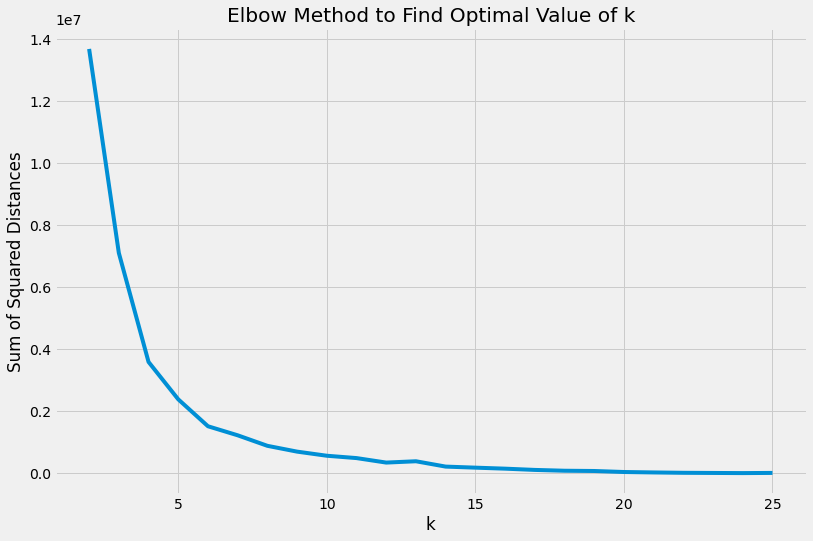

In [40]:
plt.plot(range(2,26), ssd)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method to Find Optimal Value of k')

# Combine Plots into .gif

In [29]:
def png_to_gif(path_to_images, save_file_path, duration=500):
    frames = []
    images = glob.glob(f'{path_to_images}')
    
    for i in sorted(images): 
        im = Image.open(i)
        im = im.resize((550,389),Image.ANTIALIAS)
        frames.append(im.copy())
    
    frames[0].save(f'{save_file_path}', format='GIF', append_images=frames[1:], save_all=True,
                   duration=duration, loop=0)

In [36]:
png_to_gif(path_to_images='./plots/pickup_kmeans/*.png', 
           save_file_path='./plots/pickup_kmeans/pickup_kmeans_clusters.gif',
           duration=500)

In [1]:
from IPython.display import HTML
HTML('<img src="./img/pickup_kmeans_clusters.gif">')